# 23-1 Maching Learning Term project


In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn
import statsmodels.formula.api as smf 

In [79]:
# Preprocessing
data = pd.DataFrame(columns=['Count', 'IsCorrect_mean', 'Confidence'])

# IsCorrect의 평균값, Question의 응답 갯수(Count)를 계산
train_task_data = pd.read_csv('data/train_data/train_task_3_4.csv')
for k,df in train_task_data.groupby('QuestionId'):
    data.loc[k] = len(df), df['IsCorrect'].mean(), 0

# Confidence가 없는 데이터에 Confidence의 평균값을 대입
answer_metadata = pd.read_csv('data/meta_data/answer_metadata_task_3_4.csv')

# Confidence 열이 NaN인 행 찾기
nan_rows = answer_metadata[answer_metadata['Confidence'].isna()]
confidence_mean = answer_metadata.loc[~answer_metadata['Confidence'].isna(), 'Confidence'].mean()
answer_metadata.loc[nan_rows.index, 'Confidence'] = confidence_mean

# AnswerId를 1:1 매핑하여 QuestionId AnswerId Confidence 속성으로 구성된 새로운 DataFrame 생성
merged_data = pd.merge(train_task_data, answer_metadata, on='AnswerId')[['QuestionId', 'AnswerId', 'Confidence']]
merged_data = merged_data.groupby(['QuestionId', 'AnswerId']).mean().reset_index()

In [80]:
# data DataFrame의 Confidence 열 채우기
# [참고] Colab 기준, 4분 정도의 시간이 걸립니다.
for i, row in merged_data.iterrows():
    data.loc[row['QuestionId'], 'Confidence'] = row['Confidence'] - np.random.randint(confidence_mean)

data

,Count,IsCorrect_mean,Confidence
0,2812.0,0.443457,54.608704
1,14.0,0.571429,26.608704
2,2313.0,0.385214,50.608704
3,2672.0,0.808757,66.608704
4,1704.0,0.401408,19.000000
...,...,...,...
943,2653.0,0.566528,40.608704
944,189.0,0.142857,40.608704
945,2337.0,0.422336,34.608704
946,111.0,0.459459,39.608704


In [175]:
# Methods

lm = smf.ols(formula='I(data.index) ~ (Confidence + (abs(50-IsCorrect_mean))/Count) - I(data.index/1000)', data=data)
lm_fit = lm.fit()
lm_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          I(data.index)   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     4.015
Date:                Tue, 09 May 2023   Prob (F-statistic):            0.00746
Time:                        20:34:51   Log-Likelihood:                -6659.2
No. Observations:                 948   AIC:                         1.333e+04
Df Residuals:                     944   BIC:                         1.335e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                        1.02e+04   2913.938      3.500      0.000    4479.624    1.59e+04
Confidence                        -0.1423      0.347     -0.410      0.682      -0.823       0.538
abs(50 - IsCorrect_mean)        -195.8955     58.800     -3.332      0.001    -311.289     -80.502
abs(50 - IsCorrect_mean):Count    -0.0003      0.000     -1.777      0.076      -0.001    3.44e-05
==============================================================================
Omnibus:                      550.196   Durbin-Watson:                   0.026
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               54.128
Skew:                           0.023   Prob(JB):                     1.76e-12
Kurtosis:                       1.830   Cond. No.                     2.88e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.88e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

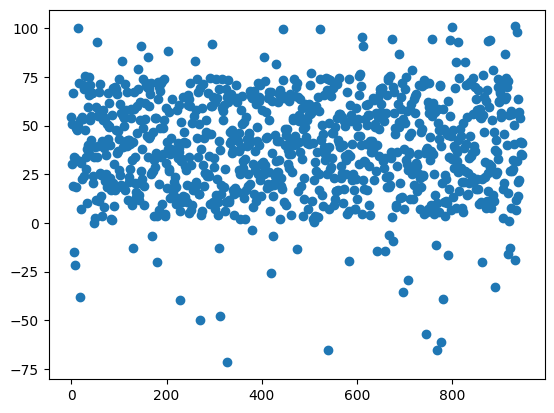

In [173]:
plt.scatter(data.index, ((data.Confidence) + abs(50-data.IsCorrect_mean)/data.Count) + data.index/1000)

In [167]:
# 예측값 계산
predicted = lm_fit.predict(data)

# 예측값 기준으로 데이터프레임 정렬
data_sorted = data.iloc[predicted.argsort()[::-1]]

# 정렬된 데이터프레임에서 index 추출
index_sorted = data_sorted.index

# 먼저, 데이터프레임에서 y축 값을 기준으로 정렬한 새로운 데이터프레임 생성
sorted_data = data.loc[index_sorted]

# 새로운 데이터프레임에서 index를 사용하여 QuestionId와 ranking 속성을 가진 리스트를 생성
template = pd.DataFrame({'QuestionId': sorted_data.index, 'ranking': range(1, len(data)+1)})

# csv 파일로 저장
template.to_csv('submission/template.csv', index=False)

## 841, 660, 847, 422, 733, 928, 511, 315, 429, 153 ...
## ... 931, 282, 599, 856, 182,  93, 276, 155, 528, 500

In [168]:
# 평가

template = pd.read_csv('submission/template.csv')
len(template)

948

In [169]:
template.head()

,QuestionId,ranking
0,841,1
1,660,2
2,847,3
3,422,4
4,733,5


In [176]:
eval_dev = pd.read_csv('data/test_data/quality_response_remapped_private.csv')

def evaluate(truth, submission):
    # extract ranking
    left = list(truth.left)
    right = list(truth.right)
#     if len(left) != len(right):
#     message = 'left and right lengths are not the same'
#     sys.exit(message)

    submission_left = []
    submission_right = []
    submission_preference = []
    for idx in range(len(left)):
        submission_left.append(left[idx])
        submission_right.append(right[idx])
        ranking_left = submission[submission.QuestionId==left[idx]].ranking.values[0]
        ranking_right = submission[submission.QuestionId==right[idx]].ranking.values[0]
        preference = 1 if ranking_left < ranking_right else 2
        submission_preference.append(preference)
    print(submission_preference)
    
evaluate(eval_dev, template)

[1, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 2, 1, 2, 1, 2, 2, 1, 1]
